<a href="https://colab.research.google.com/github/SofiNurul/SKRIPSI/blob/main/KLUSTERING_ANALISIS_SENTIMEN_ULASAN_PRODUK_PENGHILANG_BEKAS_LUKA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library**

---




In [60]:
import pandas as pd
import re
import string
import nltk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support

Mengunduh resource nltk yang diperlukan



In [61]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **Information Extraction (IE) & Information Retrieval (IR) : Import Dataset**

---



Muat dataset

In [62]:
# Memuat dataset
df = pd.read_csv('data_kotor.csv', encoding='MacRoman')
# Menampilkan 5 data teratas dan 5 data terakhir
df_combined = pd.concat([df.head(5), df.tail(5)], axis=0)
# Menampilkan hasil
df_combined

,username,date,content,score
0,z*****e,10/10/2024,Pertama kali coba karena baca ulasan di Quora ...,4
1,dindardew,03/09/2024,Penasaran bgt dari dulu udah laser jg bekas lu...,5
2,dikamungil,03/09/2024,"Udah ku pke beberapa kali sih, semoga bermanfa...",5
3,cakranouval,11/08/2024,"kecewa, kemasan penyok",3
4,ilhamansyari22,18/06/2024,Barang sesuai pesanan √¢Àú¬∫√Ø¬∏¬è,5
1169,Pengguna Shopee,10/10/2019,Bismillah semoga cocok guys. Ini sepertinya ha...,5
1170,faizarik22,09/10/2019,Masih mau nyobak sih. Soon mungkin 1 tahun ked...,5
1171,faratania,30/09/2019,Respon cepat. Produk superrrr bagusssss. Ini u...,5
1172,ayanara_,21/09/2019,"Ini seriusan pesen tanggal 20, trus tgl 21 uda...",5
1173,yuanrayi05,14/03/2019,Udh Beli 2x alhamdulillah Ada hasilnya Dan dpt...,5


# **Natural Language Processing (NLP)**

---




Pembersihan teks

In [63]:
# Fungsi untuk membersihkan teks
def clean_text(teks):
    if not isinstance(teks, str):
        return ""
    teks = teks.lower()
    teks = re.sub(r'http\S+|www\S+|https\S+', '', teks)  # Menghapus URL
    teks = re.sub(r'[^\x00-\x7F]+', ' ', teks)  # Menghilangkan karakter non-ASCII
    teks = teks.translate(str.maketrans('', '', string.punctuation))  # Menghapus tanda baca
    teks = re.sub(r'\d+', '', teks)  # Menghapus angka
    return teks

# Fungsi untuk tokenisasi
def tokenize(teks):
    return teks.split()

# Fungsi untuk menghapus stopwords
def remove_stopwords(tokens, stopwords_set):
    return [word for word in tokens if word not in stopwords_set]

# Fungsi untuk stemming
def apply_stemming(tokens, stemmer):
    return [stemmer.stem(token) for token in tokens]

# Fungsi untuk menjalankan semua tahapan preprocessing
def preprocess_text(teks, stopwords_set, stemmer):
    cleaned_text = clean_text(teks)               # Membersihkan teks
    tokens = tokenize(cleaned_text)               # Tokenisasi
    filtered_tokens = remove_stopwords(tokens, stopwords_set)  # Menghapus stopwords
    stemmed_tokens = apply_stemming(filtered_tokens, stemmer)  # Melakukan stemming
    return {
        "cleaned_text": cleaned_text,
        "tokens": tokens,
        "filtered_tokens": filtered_tokens,
        "stemmed_tokens": stemmed_tokens
    }

Inisialisasi Stopwords dan Stemmer

In [64]:
stopwords_tambahan = set([
    'gk', 'yg', 'nya', 'dan', 'dll', 'saja', 'juga', 'untuk', 'dengan', 'atau',
    'tapi', 'karena', 'seperti', 'yang', 'saya', 'ga', 'malah', 'tidak', 'lagi',
    'ini', 'di', 'kok', 'aja', 'gak', 'jadi', 'ya', 'dah', 'bisa', 'ada', 'bgt',
    'banget', 'kak', 'ituu', 'grgr', 'jd', 'pengen', 'dgn', 'udah', 'klo', 'tp',
    'pa', 'udh', 'karin', 'bgtt', 'ig', 'po', 'tau', 'utk', 'karna', 'brangnya',
    'ngk', 'kyk', 'sy', 'tp', 'uda', 'nga', 'dngn', 'kalo', 'gamau', 'becak', 'kya',
    'sma', 'jdi', 'ad', 'lg', 'pa', 'huhu', 'dpt', 'gel', 'b', 'jg', 'rb', 'hehe',
    'pdhl', 'dr', 'ku', 'sih', 'ka', 'kyk', 'sy', 'bli', 'skali', 'dikrim', 'berharap',
    'kirim', 'jdi', 'pkai', 'penjual', 'brangnya', 'becak', 'tpi', 'blum', 'bgin','aku','beli','ya','ini','ga','udah','di',
])
nltk_stopwords = set(stopwords.words('indonesian'))  # Mengambil stopwords dari NLTK
final_stopwords = nltk_stopwords.union(stopwords_tambahan)  # Menggabungkan stopwords NLTK dengan tambahan

# Membuat objek stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

Proses Preprocessing Data

In [65]:
df_selected = df[['content']]

# Terapkan preprocessing
processed_data = df_selected['content'].apply(
    lambda x: preprocess_text(x, final_stopwords, stemmer)
)

Mengonversi Hasil ke DataFrame


In [66]:
df_selected['cleaned_text'] = processed_data.apply(lambda x: x['cleaned_text'])
df_selected['tokens'] = processed_data.apply(lambda x: x['tokens'])
df_selected['filtered_tokens'] = processed_data.apply(lambda x: x['filtered_tokens'])
df_selected['stemmed_tokens'] = processed_data.apply(lambda x: x['stemmed_tokens'])

<ipython-input-66-a3fd6e419c4a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['cleaned_text'] = processed_data.apply(lambda x: x['cleaned_text'])
<ipython-input-66-a3fd6e419c4a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['tokens'] = processed_data.apply(lambda x: x['tokens'])


 Menampilkan Hasil

In [67]:
print("\n=== Hasil Preprocessing 10 Data Teratas ===")
for index, row in df_selected.head(10).iterrows():  # Mengambil hanya 10 data teratas
    print(f"Teks Asli: {row['content']}")
    print(f"Setelah Cleaning: {row['cleaned_text']}")
    print(f"Setelah Tokenizing: {row['tokens']}")
    print(f"Setelah Stopwords Removal: {row['filtered_tokens']}")
    print(f"Setelah Stemming: {row['stemmed_tokens']}")
    print("-" * 50)


=== Hasil Preprocessing 10 Data Teratas ===
Teks Asli: Pertama kali coba karena baca ulasan di Quora katanya bagus, semoga ngefek bekas2 korengan pas hamil anak ke 2 memudar, hasilnya pemakaian 1 botol insyaallah akan aku update ya.. kalo emang bagus pasti repurchase (beli lagi) di toko ini, Sellernya ramah dan amanah.. suka kalo di chat gercep di balas gak pake lama, pengiriman ke Jakarta juga cepat.
Setelah Cleaning: pertama kali coba karena baca ulasan di quora katanya bagus semoga ngefek bekas korengan pas hamil anak ke  memudar hasilnya pemakaian  botol insyaallah akan aku update ya kalo emang bagus pasti repurchase beli lagi di toko ini sellernya ramah dan amanah suka kalo di chat gercep di balas gak pake lama pengiriman ke jakarta juga cepat
Setelah Tokenizing: ['pertama', 'kali', 'coba', 'karena', 'baca', 'ulasan', 'di', 'quora', 'katanya', 'bagus', 'semoga', 'ngefek', 'bekas', 'korengan', 'pas', 'hamil', 'anak', 'ke', 'memudar', 'hasilnya', 'pemakaian', 'botol', 'insyaallah',

In [68]:
import os

# Simpan hasil preprocessing ke file CSV
output_file = "hasil_preprocessing.csv"
df_selected.to_csv(output_file, index=False)

print(f"Hasil preprocessing telah disimpan ke file: {os.path.abspath(output_file)}")

Hasil preprocessing telah disimpan ke file: /content/hasil_preprocessing.csv


# **CLUSTERING**

---



Tranformasi Data Menjadi Fitur Numerik

In [69]:
#Transformasi teks dengan TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1200)  # Maksimal 1000 fitur untuk mengurangi kompleksitas
df_selected['processed_text'] = df_selected['stemmed_tokens'].apply(lambda tokens: ' '.join(tokens))  # Gabungkan token menjadi string
tfidf_matrix = tfidf_vectorizer.fit_transform(df_selected['processed_text'])

# Menampilkan 5 ulasan teratas setelah transformasi TF-IDF
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)

print("=== 5 Ulasan Teratas Setelah Transformasi TF-IDF ===")
print(tfidf_df.head(5))

=== 5 Ulasan Teratas Setelah Transformasi TF-IDF ===
   aamiin  aamin  abis  adain  adakan  adha  admin  adminnya  after  afternya  \
0     0.0    0.0   0.0    0.0     0.0   0.0    0.0       0.0    0.0       0.0   
1     0.0    0.0   0.0    0.0     0.0   0.0    0.0       0.0    0.0       0.0   
2     0.0    0.0   0.0    0.0     0.0   0.0    0.0       0.0    0.0       0.0   
3     0.0    0.0   0.0    0.0     0.0   0.0    0.0       0.0    0.0       0.0   
4     0.0    0.0   0.0    0.0     0.0   0.0    0.0       0.0    0.0       0.0   

   ...  yeyyy  ygy  you  youu  youuu  youuuuuuuuu  yra  yuhuu  yuk  zonk  
0  ...    0.0  0.0  0.0   0.0    0.0          0.0  0.0    0.0  0.0   0.0  
1  ...    0.0  0.0  0.0   0.0    0.0          0.0  0.0    0.0  0.0   0.0  
2  ...    0.0  0.0  0.0   0.0    0.0          0.0  0.0    0.0  0.0   0.0  
3  ...    0.0  0.0  0.0   0.0    0.0          0.0  0.0    0.0  0.0   0.0  
4  ...    0.0  0.0  0.0   0.0    0.0          0.0  0.0    0.0  0.0   0.0  

[5 rows x


=== Hasil Klustering (10 Data Pertama: Positif dan Negatif) ===
                                       processed_text  cluster sentiment
0   kali coba baca ulas quora bagus moga ngefek be...        1   Positif
1   penasaran laser bekas luka ilang nemu produk c...        1   Positif
2   pke kali moga manfaat makasih seller harga mah...        1   Positif
3                                 kecewa kemas penyok        1   Positif
4                                 barang sesuai pesan        1   Positif
..                                                ...      ...       ...
95          blm kliatan hasil nnti klw dh hasil nilai        1   Positif
96                                        mahal harga        1   Positif
97                                  ubah sekalikecewa        1   Positif
98    kirim selisih refund ganti sorry bintang kecewa        0   Negatif
99                                   coba smoga cocok        1   Positif

[100 rows x 3 columns]


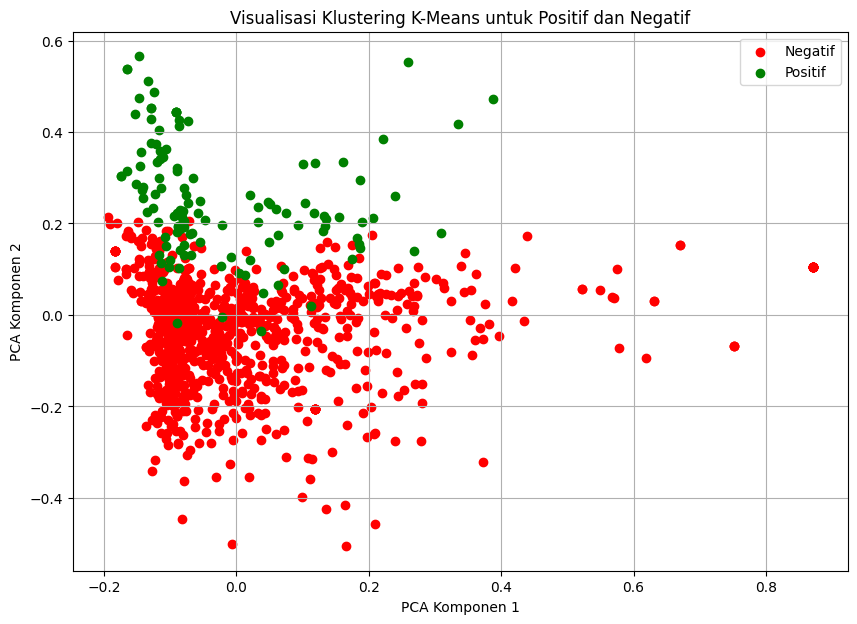

In [70]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
num_clusters = 2  # Jumlah kluster
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Definisikan jumlah kluster (hanya untuk positif dan negatif)
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Tambahkan label kluster ke DataFrame
df_selected['cluster'] = kmeans.labels_

# Definisikan label sentimen untuk tiap kluster (hanya Positif dan Negatif)
cluster_labels = {0: 'Negatif', 1: 'Positif'}
df_selected['sentiment'] = df_selected['cluster'].map(cluster_labels)

# Filter data untuk hanya menampilkan kluster Positif dan Negatif
df_filtered = df_selected[df_selected['sentiment'].isin(['Positif', 'Negatif'])]

# Menampilkan hasil klustering untuk 10 data pertama dari Positif dan Negatif
print("\n=== Hasil Klustering (10 Data Pertama: Positif dan Negatif) ===")
print(df_filtered[['processed_text', 'cluster', 'sentiment']].head(100))

# Visualisasi Klustering
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(10, 7))
colors = ['red', 'green']  # Warna untuk Negatif dan Positif
labels = ['Negatif', 'Positif']

# Visualisasi hanya untuk kluster yang dipilih
for cluster, color, label in zip(df_filtered['cluster'].unique(), colors, labels):
    cluster_points = reduced_features[df_filtered['cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=color, label=label)

plt.legend()
plt.title("Visualisasi Klustering K-Means untuk Positif dan Negatif")
plt.xlabel("PCA Komponen 1")
plt.ylabel("PCA Komponen 2")
plt.grid(True)
plt.show()


=== Sebaran Sentimen ===
sentiment
Positif    1049
Negatif     125
Name: count, dtype: int64


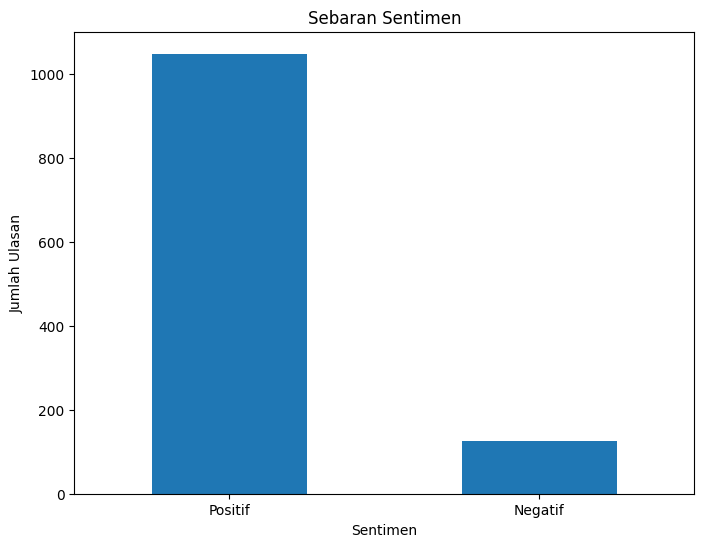

In [71]:
# Menghitung sebaran sentimen
sentiment_distribution = df_selected['sentiment'].value_counts()

# Menampilkan hasil sebaran
print("\n=== Sebaran Sentimen ===")
print(sentiment_distribution)

# Visualisasi sebaran sentimen
plt.figure(figsize=(8, 6))
sentiment_distribution.plot(kind='bar')
plt.title("Sebaran Sentimen")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah Ulasan")
plt.xticks(rotation=0)
plt.show()

# **Categorization : Klasifikasi Algortima Naive Bayes**

---



In [72]:
from sklearn.preprocessing import LabelEncoder
#Pastikan `tfidf_matrix` sebagai fitur dan `df_selected['sentiment']` sebagai label
X = tfidf_matrix
y = df_selected['sentiment']

# Encode label sentimen menjadi numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Pembagian data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print("Jumlah Data Latih:", X_train.shape[0])
print("Jumlah Data Uji:", X_test.shape[0])

# === GridSearchCV untuk Optimasi Model Naive Bayes ===

# Definisikan parameter yang ingin dicari
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]  # Nilai smoothing untuk MultinomialNB
}

# Inisialisasi model Naive Bayes
nb_model = MultinomialNB()

# GridSearchCV untuk mencari parameter terbaik
grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Menampilkan parameter terbaik
best_params = grid_search.best_params_
print(f"\n=== Parameter Terbaik: {best_params} ===")

# Menggunakan model terbaik untuk prediksi
best_nb_model = grid_search.best_estimator_
y_pred = best_nb_model.predict(X_test)


Jumlah Data Latih: 939
Jumlah Data Uji: 235

=== Parameter Terbaik: {'alpha': 0.1} ===


Evaluasi Model


=== Confusion Matrix ===
[[ 12  13]
 [  3 207]]


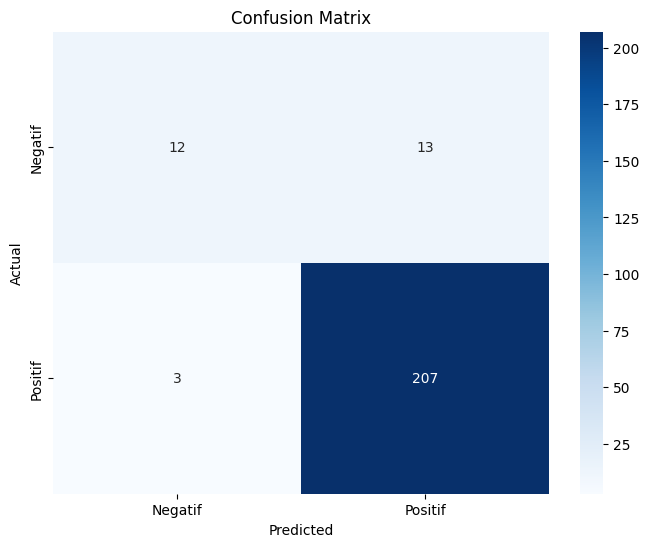


=== Classification Report ===
              precision    recall  f1-score   support

     Negatif       0.80      0.48      0.60        25
     Positif       0.94      0.99      0.96       210

    accuracy                           0.93       235
   macro avg       0.87      0.73      0.78       235
weighted avg       0.93      0.93      0.92       235


=== Akurasi Model Setelah Optimasi: 0.93 ===


In [73]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\n=== Confusion Matrix ===")
print(conf_matrix)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"\n=== Akurasi Model Setelah Optimasi: {accuracy:.2f} ===")

# **Visualization : WordCloud Setiap Sentimen**

---



WORDCLOUD UNTUK SETIAP SENTIMEN

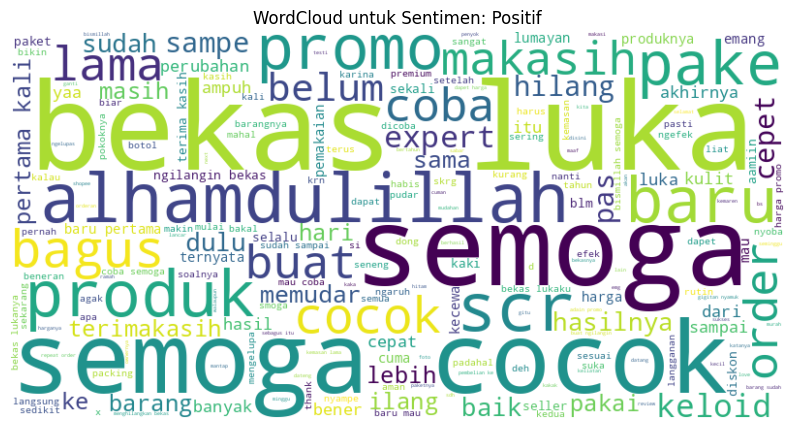

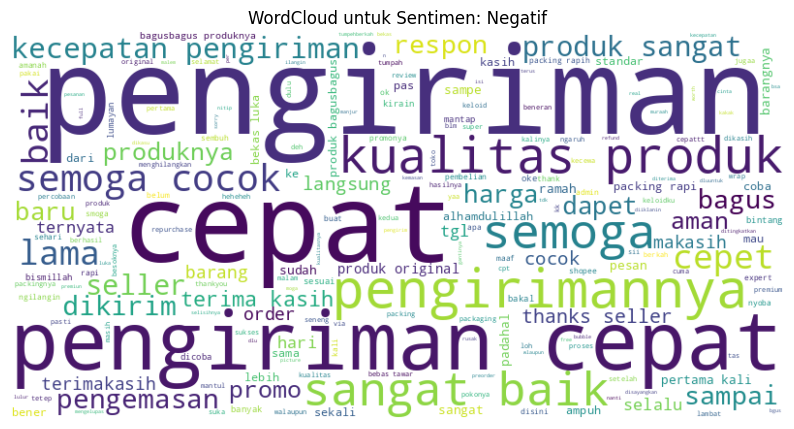

In [76]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Stopword tambahan yang Anda berikan
additional_stopwords = {
    'gk', 'yg', 'nya', 'dan', 'dll', 'saja', 'juga', 'untuk', 'dengan', 'atau',
    'tapi', 'karena', 'seperti', 'yang', 'saya', 'ga', 'malah', 'tidak', 'lagi',
    'ini', 'di', 'kok', 'aja', 'gak', 'jadi', 'ya', 'dah', 'bisa', 'ada', 'bgt',
    'banget', 'kak', 'ituu', 'grgr', 'jd', 'pengen', 'dgn', 'udah', 'klo', 'tp',
    'pa', 'udh', 'karin', 'bgtt', 'ig', 'po', 'tau', 'utk', 'karna', 'brangnya',
    'ngk', 'kyk', 'sy', 'tp', 'uda', 'nga', 'dngn', 'kalo', 'gamau', 'becak', 'kya',
    'sma', 'jdi', 'ad', 'lg', 'pa', 'huhu', 'dpt', 'gel', 'b', 'jg', 'rb', 'hehe',
    'pdhl', 'dr', 'ku', 'sih', 'ka', 'kyk', 'sy', 'bli', 'skali', 'dikrim', 'berharap',
    'kirim', 'jdi', 'pkai', 'penjual', 'brangnya', 'becak', 'tpi', 'blum', 'bgin',
    'aku', 'beli', 'ya', 'ini', 'ga', 'udah', 'di'
}

# Gabungkan stopwords bawaan WordCloud dengan stopword tambahan
all_stopwords = STOPWORDS.union(additional_stopwords)

# Membuat WordCloud untuk setiap sentimen
def generate_wordcloud(sentiment_label, df, stopwords):
    # Filter teks berdasarkan sentimen
    text = " ".join(df[df['sentiment'] == sentiment_label]['cleaned_text'])

    # Membuat WordCloud dengan stopwords
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=stopwords
    ).generate(text)

    # Menampilkan WordCloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud untuk Sentimen: {sentiment_label}")
    plt.show()

# Sentimen unik
sentiments = df_selected['sentiment'].unique()

# Generate WordCloud untuk setiap sentimen
for sentiment in sentiments:
    generate_wordcloud(sentiment, df_selected, all_stopwords)
